<a href="https://colab.research.google.com/github/Mostafa-Mohamed-Atef/NN-Email-Classification-IS/blob/master/NN_Email_Classification_IS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
advaithsrao_enron_fraud_email_dataset_path = kagglehub.dataset_download('advaithsrao/enron-fraud-email-dataset')

print('Data source import complete.')


100%|██████████| 214M/214M [00:01<00:00, 131MB/s]

Extracting files...


Data source import complete.


# Loading Dataset

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("advaithsrao/enron-fraud-email-dataset")

df = pd.read_csv(os.path.join(path, 'enron_data_fraud_labeled.csv'))  # Update `path` to your dataset's location
df.head()


<ipython-input-3-931de8d3c01f>:6: DtypeWarning: Columns (7,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(path, 'enron_data_fraud_labeled.csv'))  # Update `path` to your dataset's location


,Folder-User,Folder-Name,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,...,Re,Source,Mail-ID,POI-Present,Suspicious-Folders,Sender-Type,Unique-Mails-From-Sender,Low-Comm,Contains-Reply-Forwards,Label
0,maildir,arnold-j,<17334447.1075857585446.JavaMail.evans@thyme>,"Thu, 16 Nov 2000 09:30:00 -0800 (PST)",msagel@home.com,jarnold@enron.com,Status,1.0,text/plain; charset=ANSI_X3.4-1968,7bit,...,,Enron Data,b399fa1ba5ec06ccf8ead1049a53be981d0ebb39ee2c94...,False,False,External,18.0,False,False,0
1,maildir,arnold-j,<19171686.1075857585034.JavaMail.evans@thyme>,"Fri, 8 Dec 2000 05:05:00 -0800 (PST)",slafontaine@globalp.com,john.arnold@enron.com,re:summer inverses,1.0,text/plain; charset=us-ascii,7bit,...,,Enron Data,84b07d7a0a17b545896f670f92d200e86843c2796147d9...,False,False,External,4.0,True,False,0
2,maildir,arnold-j,<29887033.1075857630725.JavaMail.evans@thyme>,"Tue, 15 May 2001 09:43:00 -0700 (PDT)",iceoperations@intcx.com,"icehelpdesk@intcx.com, internalmarketing@intcx...",The WTI Bullet swap contracts,1.0,text/plain; charset=us-ascii,7bit,...,,Enron Data,f7482dd06262f46d341e733aa0c2fb55cb1e257ea153d0...,False,False,External,3.0,True,False,0
3,maildir,arnold-j,<2526360.1075857584903.JavaMail.evans@thyme>,"Mon, 11 Dec 2000 23:52:00 -0800 (PST)",klarnold@flash.net,john.arnold@enron.com,Fwd: NYTimes.com Article: Suspended Rabbi Quit...,1.0,text/plain; charset=us-ascii,7bit,...,,Enron Data,25441e5a837fefda50527731fdbcdf0848663be82cd1ce...,False,False,External,9.0,False,True,0
4,maildir,arnold-j,<30102065.1075857630952.JavaMail.evans@thyme>,"Mon, 14 May 2001 23:59:00 -0700 (PDT)",soblander@carrfut.com,soblander@carrfut.com,daily charts and matrices as hot links 5/15,1.0,text/plain; charset=us-ascii,7bit,...,,Enron Data,c2995c6a70b953ee66c21d8a509ebfbfaca28277917beb...,False,False,External,352.0,False,False,0


# Step 1: Clean and preprocess the data

In [4]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_email(email):
    if pd.isnull(email):
        return ""
    # Remove non-alphabetic characters and stopwords
    email = ' '.join([word for word in email.split() if word.isalpha() and word.lower() not in stop_words])
    return email

df['cleaned_body'] = df['Body'].apply(preprocess_email)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Encode labels

In [5]:
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['Label'])

# Step 2: Tokenization and padding

In [6]:
X = df['cleaned_body'].fillna("")
y = df['label_encoded']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenize text data
tokenizer = Tokenizer(num_words=10000)  # Adjust vocabulary size as needed
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure uniform input size
max_length = 100  # Adjust max length based on your dataset
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

# Step 3: Build the model

In [7]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [8]:

model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=max_length),  # Embedding layer
    Bidirectional(LSTM(64, return_sequences=False)),  # LSTM layer
    Dropout(0.6),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.6),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
# model.compile(
#     optimizer='adam',
#     loss='binary_crossentropy',
#     metrics=['accuracy']
# )
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


# Step 4: Train the model

In [14]:
print("Starting training...")
history = model.fit(
    X_train_padded,
    y_train,
    validation_split=0.2,
    epochs=3,  # Adjust epochs based on dataset size
    batch_size=32,  # Adjust batch size based on your hardware
    verbose=1
)

Starting training...
Epoch 1/3
8949/8949 [==============================] - 1035s 115ms/step - loss: 0.1055 - accuracy: 0.9945 - val_loss: 0.0239 - val_accuracy: 0.9942
Epoch 2/3
8949/8949 [==============================] - 998s 112ms/step - loss: 0.0192 - accuracy: 0.9949 - val_loss: 0.0195 - val_accuracy: 0.9942
Epoch 3/3
8949/8949 [==============================] - 998s 112ms/step - loss: 0.0153 - accuracy: 0.9949 - val_loss: 0.0195 - val_accuracy: 0.9942


# Step 5: Evaluate the model

In [1]:
print("Evaluating the model...")
loss, accuracy = model.evaluate(X_test_padded, y_test, verbose=1)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Evaluating the model...


NameError: name 'model' is not defined

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, ConfusionMatrixDisplay


In [11]:
# Generate predictions
y_pred = (model.predict(X_test_padded) > 0.5).astype("int32").flatten()
print("Original class names:", label_encoder.classes_)
class_names = [str(cls) for cls in label_encoder.classes_]
# Generate classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

2797/2797 [==============================] - 60s 21ms/step
Original class names: [0 1]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.63      0.77     89017
           1       0.01      0.39      0.01       467

    accuracy                           0.63     89484
   macro avg       0.50      0.51      0.39     89484
weighted avg       0.99      0.63      0.77     89484




Confusion Matrix:


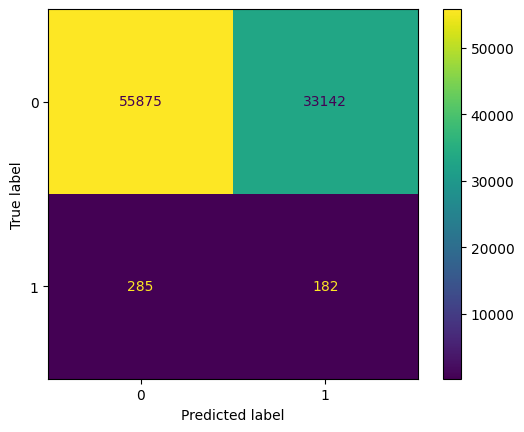

In [12]:
# Plot confusion matrix
print("\nConfusion Matrix:")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=class_names)
plt.show()

In [13]:
# Plot training vs validation accuracy curves
print("\nTraining vs. Validation Accuracy:")
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()
plt.show()

print("\nExample Predictions:")
for i, (true, pred) in enumerate(zip(y_test[:10], y_pred[:10])):
    print(f"Sample {i + 1}:")
    print(f"True Label: {true}, Predicted Label: {pred}")
    print("-" * 50)




Training vs. Validation Accuracy:


NameError: name 'history' is not defined

In [ ]:
model.save('email_classification_model.h5')